In [1]:
using Revise
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress!, TruncBondThresh  
using Printf

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

includet("../GlauberPT.jl/src/monte_carlo_efficient/observables.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/parameters.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/plots.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/swap_criteria.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/update_rules.jl")
includet("../GlauberPT.jl/src/monte_carlo_efficient/monte_carlo_general.jl")

includet("../GlauberPT.jl/src/tensor_train_efficient/auxiliary_tensor_train_tools.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/boltzmann_distribution_tt.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/efficient_observables.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/initialization_params.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/metropolis_swap_tt.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/tensor_train_evolution.jl")
includet("../GlauberPT.jl/src/tensor_train_efficient/transition_rates_builder.jl")

#### Basic Plots simple dinamics: sequential Glauber, parallel Glabuer, metropolis

In [2]:
Revise.revise()

number_of_spins = 20
n_samples = 10000
T_steps_ = 100

params = MCParameters(
    N = number_of_spins,
    betas = [1.0],
    # j_vector = fill(1.0, number_of_spins - 1),
    j_vector = rand(number_of_spins - 1),
    # h_vector = fill(1.0, number_of_spins),
    h_vector = rand(number_of_spins),
    p0 = 1/number_of_spins
)
initial_probs_ = fill(0.8, number_of_spins)
initial_probs_transformed = transform_init_cond_simple(initial_probs_)


# Correr simulación
result_simple_sequential = run_monte_carlo_general(
    params,
    N_samples = n_samples,
    initial_probs = initial_probs_,
    T_steps = T_steps_,
    update_rule = :sequential,
    observables = [:magnetization, :energy]
)

result_simple_parallel = run_monte_carlo_general(
    params,
    N_samples = n_samples,
    initial_probs = initial_probs_,
    T_steps = T_steps_,
    update_rule = :parallel,
    observables = [:magnetization, :energy]
)

result_simple_metropolis = run_monte_carlo_general(
    params,
    N_samples = n_samples,
    initial_probs = initial_probs_,
    T_steps = T_steps_,
    update_rule = :metropolis,
    observables = [:magnetization, :energy]
)



Dict{Symbol, Any} with 2 entries:
  :params      => MCParameters:…
  :observables => Dict{Symbol, Any}(:energy=>[-9.17442, -9.49053, -9.78562, -10…

In [3]:
Revise.revise()

trans_matrix_sequential_simple = build_transition_tensortrain(
    params;
    update_rule = :sequential,
    bond = 5
    );

trans_matrix_parallel_simple = build_transition_tensortrain(
    params;
    update_rule = :parallel,
    bond = 5
    );

trans_matrix_metropolis_simple = build_transition_tensortrain(
    params;
    update_rule = :metropolis,
    bond = 5
    );

In [4]:
Revise.revise()

distribution_evolution_sequential_simple = distribution_b_tt(
    trans_matrix_sequential_simple, 
    initial_probs_transformed, 
    T_steps_, 
    5,
    no_swap()
    );


distribution_evolution_parallel_simple = distribution_b_tt(
    trans_matrix_parallel_simple, 
    initial_probs_transformed, 
    T_steps_, 
    5,
    no_swap()
    );

distribution_evolution_metropolis_simple = distribution_b_tt(
    trans_matrix_metropolis_simple, 
    initial_probs_transformed, 
    T_steps_, 
    5,
    no_swap()
    );

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [5]:
Revise.revise()

sub_prod_sequential_simple = system_description_over_time_simple(distribution_evolution_sequential_simple, params);
sub_prod_parallel_simple = system_description_over_time_simple(distribution_evolution_parallel_simple, params);
sub_prod_metropolis_simple = system_description_over_time_simple(distribution_evolution_metropolis_simple, params);

In [6]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, titled="Marginal expectation per spin over steps", savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title=titled,
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

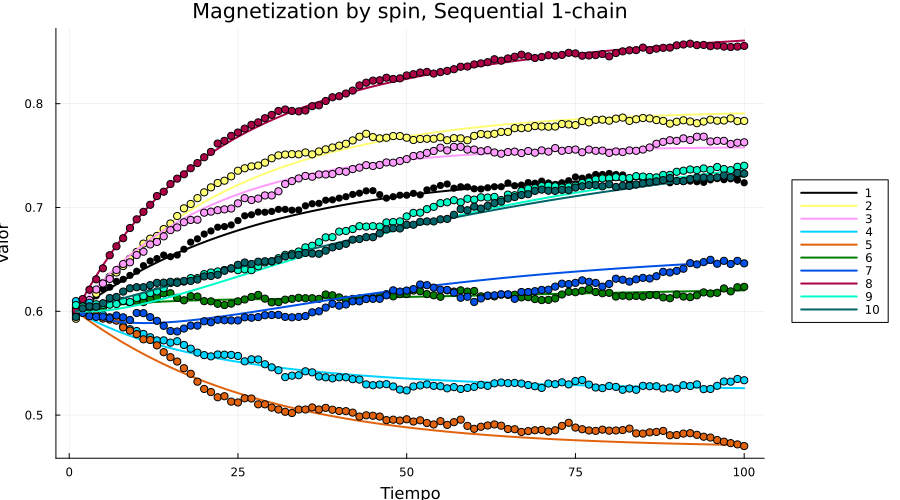

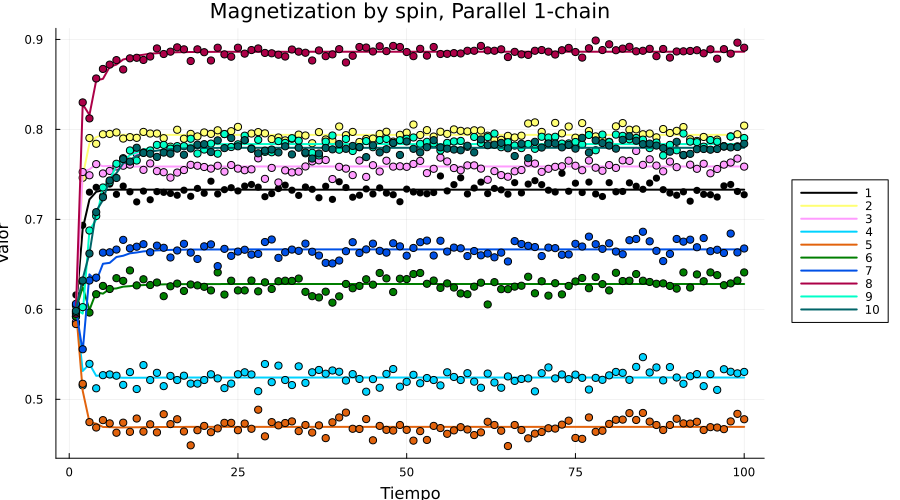

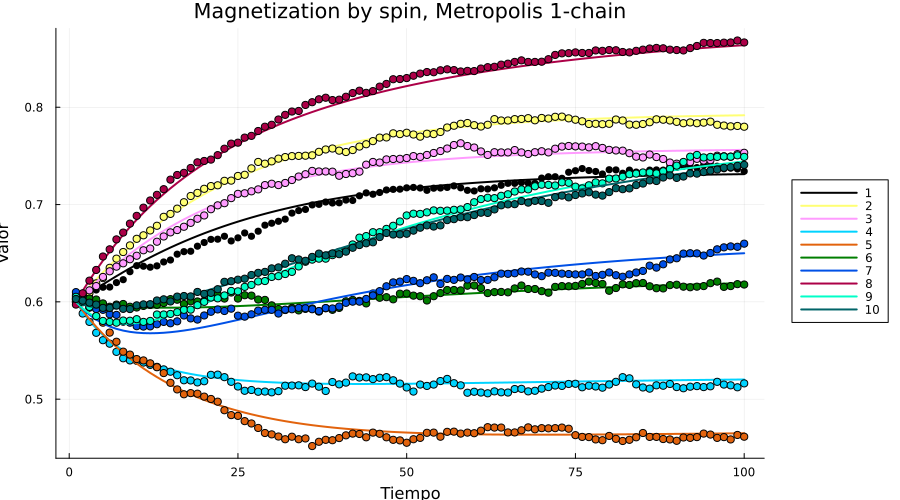

In [7]:
Revise.revise()

simple_chains_magn = [("Magnetization by spin, Sequential 1-chain", result_simple_sequential[:observables][:magnetization], sub_prod_sequential_simple[1]),
                 ("Magnetization by spin, Parallel 1-chain", result_simple_parallel[:observables][:magnetization], sub_prod_parallel_simple[1]),
                 ("Magnetization by spin, Metropolis 1-chain", result_simple_metropolis[:observables][:magnetization], sub_prod_metropolis_simple[1])
                ]


numbers_of_spins = 10
lista_of_spins = sort(randperm(numbers_of_spins)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)


for (title, magn_mc, magn_tt) in simple_chains_magn
    Sdots = magn_mc[lista_of_spins, 1:T_steps_] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T_steps_
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = magn_tt[k][spin_idx]
        end
    end
    times = 1:T_steps_            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           titled = title
                           )
    display(p)
end

In [8]:
Revise.revise()

simple_chains_energy = [("Energy, Sequential 1-chain", result_simple_sequential[:observables][:energy], sub_prod_sequential_simple[2]),
                 ("Energy, Parallel 1-chain", result_simple_parallel[:observables][:energy], sub_prod_parallel_simple[2]),
                 ("Energy, Metropolis 1-chain", result_simple_metropolis[:observables][:energy], sub_prod_metropolis_simple[2])
                ];


energy_to_converge =  boltzman_tt(params)  
normalize!(energy_to_converge)
eq_energy = energy_function_simple(energy_to_converge, params);


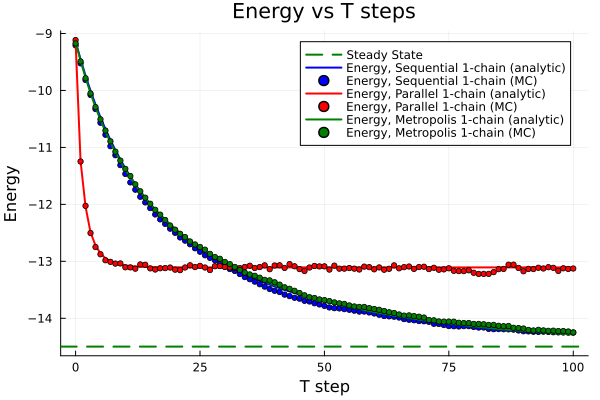

In [9]:
Revise.revise()

times = 0:T_steps_
colors = [:blue, :red, :green]

p = plot(
    title = "Energy vs T steps",
    xlabel = "T step",
    ylabel = "Energy",
    legend = :best
)

hline!(p, [eq_energy], 
    color=:green, 
    linestyle=:dash, 
    lw=2,
    label="Steady State")

for (i, (label, energy_mc, energy_anal)) in enumerate(simple_chains_energy)
    # Analítica → línea continua
    plot!(
        p,
        times,
        energy_anal,
        lw = 2,
        color = colors[i],
        label = label * " (analytic)"
    )

    # Monte Carlo → puntos
    scatter!(
        p,
        times,
        energy_mc,
        ms = 3,
        color = colors[i],
        label = label * " (MC)"
    )
end

display(p)


#### Basic Plots multiple(2) dinamics: sequential Glauber, parallel Glabuer, metropolis

In [21]:
Revise.revise()

number_of_spins = 20
n_samples = 10000
T_steps_ = 100

multiple_params = MCParameters(
    N = number_of_spins,
    betas = [1.0, 3.0],
    # j_vector = fill(1.0, number_of_spins - 1),
    j_vector = rand(number_of_spins - 1),
    # h_vector = fill(1.0, number_of_spins),
    h_vector = rand(number_of_spins),
    p0 = 1/number_of_spins
)
initial_probs_ = fill(0.8, number_of_spins)
initial_probs_transformed_multiple = transform_init_cond_multiple(initial_probs_)


# Correr simulación
result_multiple_sequential = run_monte_carlo_general(
    multiple_params,
    N_samples = n_samples,
    initial_probs = initial_probs_,
    T_steps = T_steps_,
    update_rule = :sequential,
    observables = [:magnetization, :energy]
)

result_multiple_parallel = run_monte_carlo_general(
    multiple_params,
    N_samples = n_samples,
    initial_probs = initial_probs_,
    T_steps = T_steps_,
    update_rule = :parallel,
    observables = [:magnetization, :energy]
)

result_multiple_metropolis = run_monte_carlo_general(
    multiple_params,
    N_samples = n_samples,
    initial_probs = initial_probs_,
    T_steps = T_steps_,
    update_rule = :metropolis,
    observables = [:magnetization, :energy]
)


Dict{Symbol, Any} with 2 entries:
  :params      => MCParameters:…
  :observables => Dict{Symbol, Any}(:energy=>[-9.71316 -10.1212 … -16.0965 -16.…

In [91]:
Revise.revise()

trans_matrix_sequential_multiple = parallel_transition_tensor_train(
    params;
    update_rule = :sequential,
    bond = 5
    );

trans_matrix_parallel_multiple = parallel_transition_tensor_train(
    params;
    update_rule = :parallel,
    bond = 5
    );

trans_matrix_metropolis_multiple = parallel_transition_tensor_train(
    params;
    update_rule = :metropolis,
    bond = 5
    );

In [92]:
Revise.revise()


initial_probs_transformed_multiple = transform_init_cond_multiple(initial_probs_)

distribution_evolution_sequential_multiple = distribution_b_tt(
    trans_matrix_sequential_multiple, 
    initial_probs_transformed_multiple, 
    T_steps_, 
    5,
    no_swap()
    );


distribution_evolution_parallel_multiple = distribution_b_tt(
    trans_matrix_parallel_multiple, 
    initial_probs_transformed_multiple, 
    T_steps_, 
    5,
    no_swap()
    );

distribution_evolution_metropolis_multiple = distribution_b_tt(
    trans_matrix_metropolis_multiple, 
    initial_probs_transformed_multiple, 
    T_steps_, 
    5,
    no_swap()
    );

Progress: 100%|█████████████████████████████████████████| Time: 0:03:29
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
Progress: 100%|█████████████████████████████████████████| Time: 0:03:13


In [93]:
Revise.revise()

sub_prod_sequential_multiple = system_description_over_time(distribution_evolution_sequential_multiple, params);
sub_prod_parallel_multiple = system_description_over_time(distribution_evolution_parallel_multiple, params);
sub_prod_metropolis_multiple = system_description_over_time(distribution_evolution_metropolis_multiple, params);

In [94]:
Revise.revise()

magn_multiple_sequential = [[[result_multiple_sequential[:observables][:magnetization][:,:,t][chain,spin] for t in 1:T_steps_+1] for spin in 1:20] for chain in 1:2]
magn_multiple_parallel = [[[result_multiple_parallel[:observables][:magnetization][:,:,t][chain,spin] for t in 1:T_steps_+1] for spin in 1:20] for chain in 1:2]
magn_multiple_metropolis = [[[result_multiple_metropolis[:observables][:magnetization][:,:,t][chain,spin] for t in 1:T_steps_+1] for spin in 1:20] for chain in 1:2]

multiple_chains_magn = [("Magnetization by spin, Sequential 2-chain", magn_multiple_sequential, sub_prod_sequential_multiple.full_expected_values_t),
                 ("Magnetization by spin, Parallel 2-chain", magn_multiple_parallel, sub_prod_parallel_multiple.full_expected_values_t),
                 ("Magnetization by spin, Metropolis 2-chain", magn_multiple_metropolis, sub_prod_metropolis_multiple.full_expected_values_t)
                ];


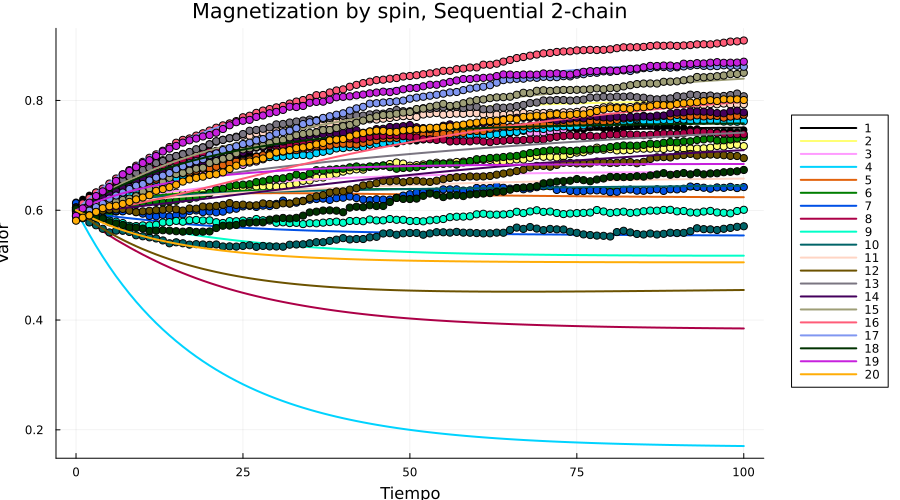

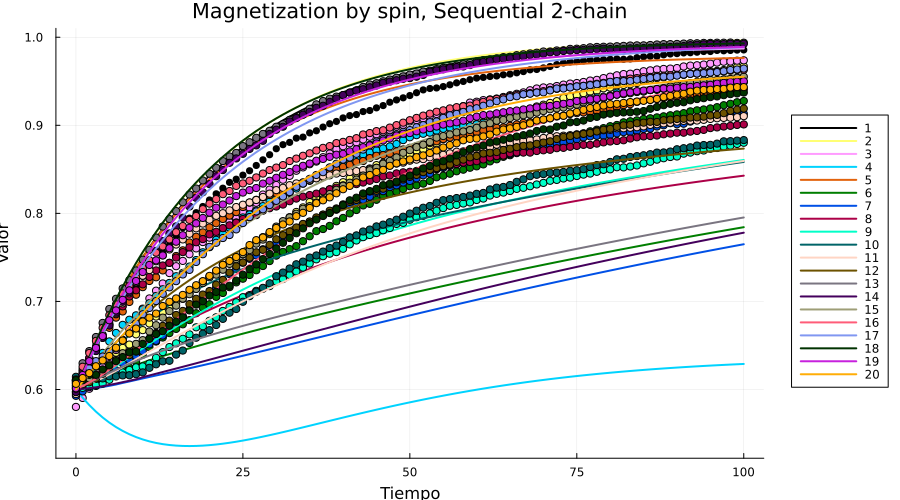

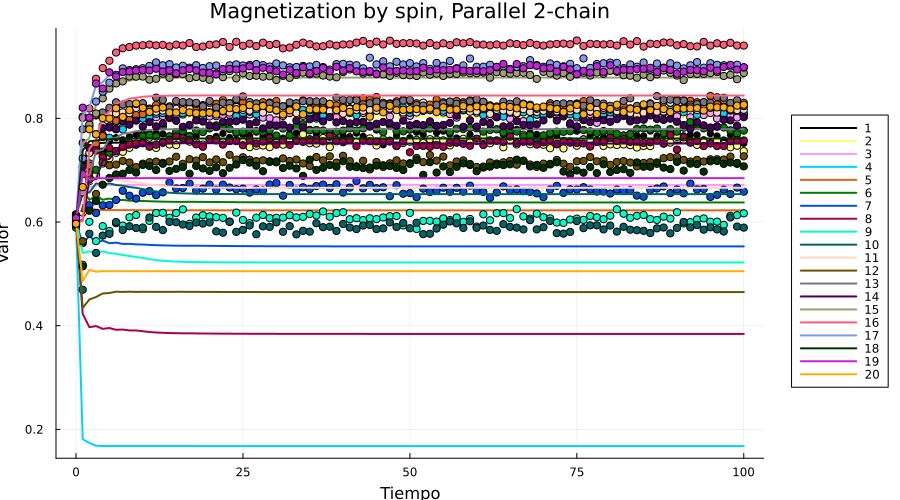

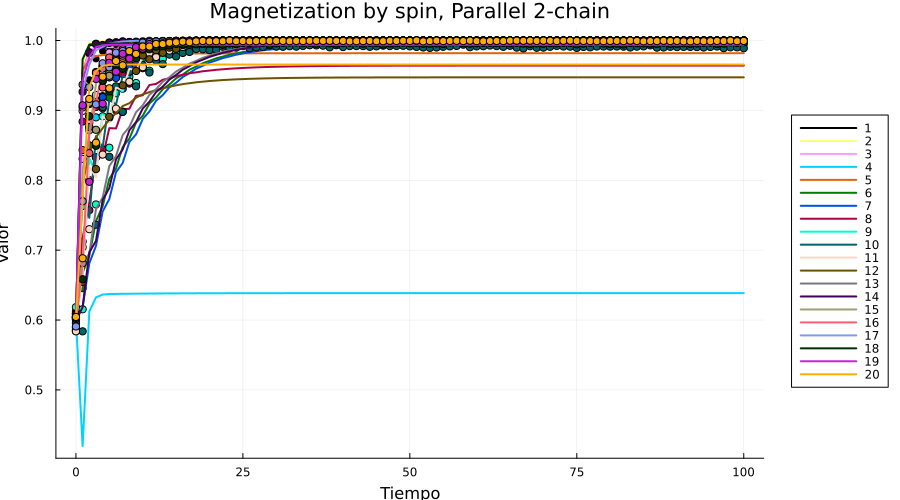

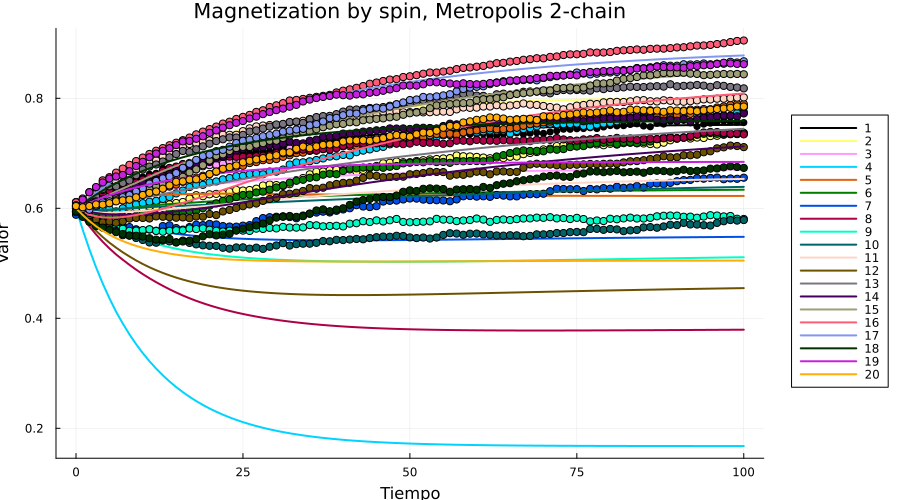

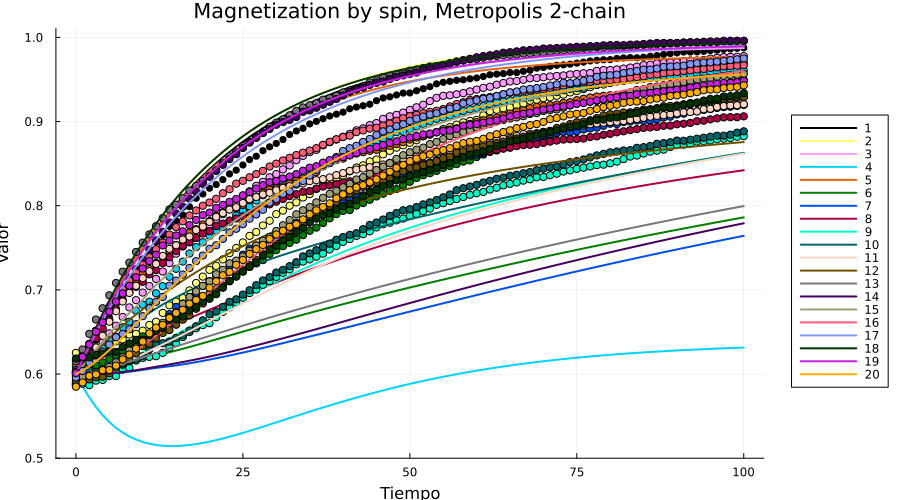

In [102]:

numbers_of_spins = 20
lista_of_spins = sort(randperm(numbers_of_spins)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)


for (title, magn_mc, magn_tt) in multiple_chains_magn
    for chain in 1:2
        Sdots = transpose(hcat(magn_mc[chain][lista_of_spins][:]...)) # N x T
        Slines = zeros(size(Sdots))                        # N x T
        for k in 1:T_steps_+1
            for j in 1:length(lista_of_spins)
                spin_idx = lista_of_spins[j]
                Slines[j, k] = magn_tt[k][spin_idx][chain]
            end
        end
        times = 0:T_steps_            # o el vector de tiempos que uses (length == size(spins_tt,2))
        p = plot_two_Ntuples(times, Sdots, Slines;
                               site_labels = str_lista,
                               titled = title
                               )
        display(p)
    end
end

In [122]:
Revise.revise()

multiple_chains_energy = [("Energy, Sequential 1-chain", result_multiple_sequential[:observables][:energy], [[sub_prod_sequential_multiple.energy_t[t][chain] for t in 1:T_steps_+1] for chain in 1:2]),
                 ("Energy, Parallel 1-chain", result_multiple_parallel[:observables][:energy], [[sub_prod_parallel_multiple.energy_t[t][chain] for t in 1:T_steps_+1] for chain in 1:2]),
                 ("Energy, Metropolis 1-chain", result_multiple_metropolis[:observables][:energy], [[sub_prod_metropolis_multiple.energy_t[t][chain] for t in 1:T_steps_+1] for chain in 1:2])
                ];


energy_to_converge_1 =  boltzman_tt(params)  
normalize!(energy_to_converge_1)
eq_energy_1 = energy_function_simple(energy_to_converge_1, params);

energy_to_converge_2 =  boltzman_tt(params; coc= params.betas[2]/params.betas[1])  
normalize!(energy_to_converge_2)
eq_energy_2 = energy_function_simple(energy_to_converge_2, params);

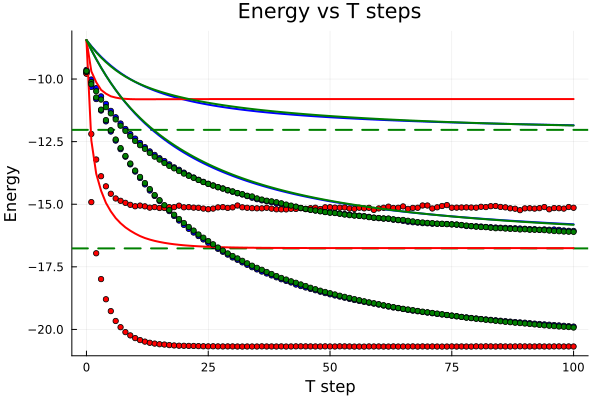

In [123]:
Revise.revise()

times = 0:T_steps_
colors = [:blue, :red, :green]

p = plot(
    title = "Energy vs T steps",
    xlabel = "T step",
    ylabel = "Energy",
    legend = :best
)

hline!(p, [eq_energy_1], 
    color=:green, 
    linestyle=:dash, 
    lw=2,
    label="Steady State")

hline!(p, [eq_energy_2], 
    color=:green, 
    linestyle=:dash, 
    lw=2,
    label="Steady State")

for (i, (label, energy_mc, energy_anal)) in enumerate(multiple_chains_energy)
    # Analítica → línea continua
    for chain in 1:2
        plot!(
            p,
            times,
            energy_anal[chain],
            lw = 2,
            color = colors[i],
            label = label * " Chain $chain (analytic)"
        )
    

        # Monte Carlo → puntos
        scatter!(
            p,
            times,
            energy_mc[chain,:],
            ms = 3,
            color = colors[i],
            label = label * " (MC)"
        )
    end
end
plot!(legend = :false)   # fuera a la derecha
display(p)


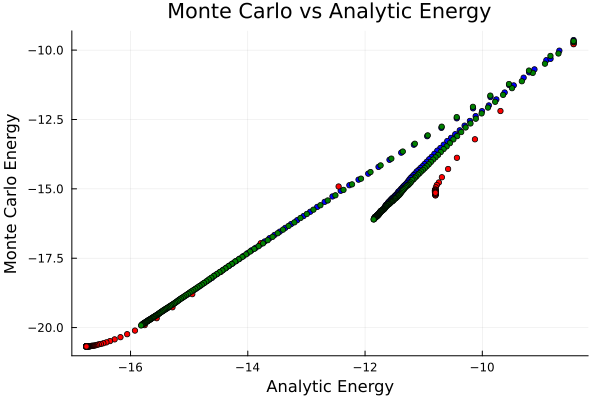

In [125]:
using Plots

p = plot(
    title = "Monte Carlo vs Analytic Energy",
    xlabel = "Analytic Energy",
    ylabel = "Monte Carlo Energy",
    legend = false,   # leyenda desactivada
    seriestype = :scatter
)

colors = [:blue, :red, :green]  # puedes usar tus colores

for (i, (label, energy_mc, energy_anal)) in enumerate(multiple_chains_energy)
    for chain in 1:2
        # Scatter MC vs Analytic
        scatter!(
            p,
            energy_anal[chain],      # eje X = analítico
            energy_mc[chain,:],      # eje Y = MC
            color = colors[i],
            ms = 3
        )
    end
end

display(p)


DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size: a has axes Base.OneTo(2) and b has axes Base.OneTo(3)